# Import Librairies

In [14]:
import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout 
from keras.layers import Conv2DTranspose
from keras.layers import concatenate

# Load Data

In [15]:
src_list_train = sorted(glob.glob('data/leftImg8bit/train/*/*.png'))
seg_list_train = sorted(glob.glob('data/gtFine/train/*/*_labelIds.png'))

# Preprocess Data

In [3]:
def process_path(src_path, seg_path):
    src = tf.io.read_file(src_path) # Returns a Tensor with the entire contents of the input filename.
    src = tf.image.decode_png(src, channels=3) # Decode a PNG-Encoded image to a Tensor (RGB Image -> 3).
    src = tf.image.convert_image_dtype(src, tf.float32) # Convert image -> dtype.

    seg = tf.io.read_file(seg_path)
    seg = tf.image.decode_png(seg, channels=3)
    seg = tf.math.reduce_max(seg, axis=-1, keepdims=True) # Computes maximum of elements across dimensions of a tensor (-1 -> the 3rd Dim.)
    return src, seg

def preprocess(image, mask):
    input_src = tf.image.resize(image, (96, 128), method='nearest') # Resized Image.
    input_seg = tf.image.resize(mask, (96, 128), method='nearest')
    input_src = input_src / 255.0 # Normalize the values to range from 0 to 1.
    return input_src, input_seg

# Create Dataset

In [6]:
src_list_d = tf.data.Dataset.list_files(src_list_train, shuffle=False) # To create a dataset of all files in the list.
seg_list_d = tf.data.Dataset.list_files(seg_list_train, shuffle=False) # The dataset here contains original images (without preprocessing).

src_filenames = tf.constant(src_list_train) # Creates a constant Tensor from a Tensor-like object (list).
seg_filenames = tf.constant(seg_list_train)

dataset = tf.data.Dataset.from_tensor_slices((src_filenames, seg_filenames)) # To create a dataset from a list (and tuples).
# It's actually a dataset of path.

src_ds = dataset.map(process_path) # Map Processing Path Function to the dataset.
processed_src_ds = src_ds.map(preprocess) # Map Pre-Processing Function to the dataset (to create a dataset of image).

# U-Net

## Encoder - Downsampling

### Convolution Down. Block

In [7]:
def downsampling_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(2, strides=2)(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    return next_layer, skip_connection

## Decoder - Upsampling

### Convolution Up. Block

In [8]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv

## Model

In [9]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=34):
    inputs = Input(input_size)

    cblock1 = downsampling_block(inputs=inputs, n_filters=n_filters*1)
    cblock2 = downsampling_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = downsampling_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = downsampling_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    cblock5 = downsampling_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

## Model Dimensions

In [10]:
img_height = 96
img_width = 128
num_channels = 3

## Create Model

In [11]:
unet = unet_model((img_height, img_width, num_channels))
unet.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Visualize Some Data

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

2023-05-10 11:06:33.292965: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


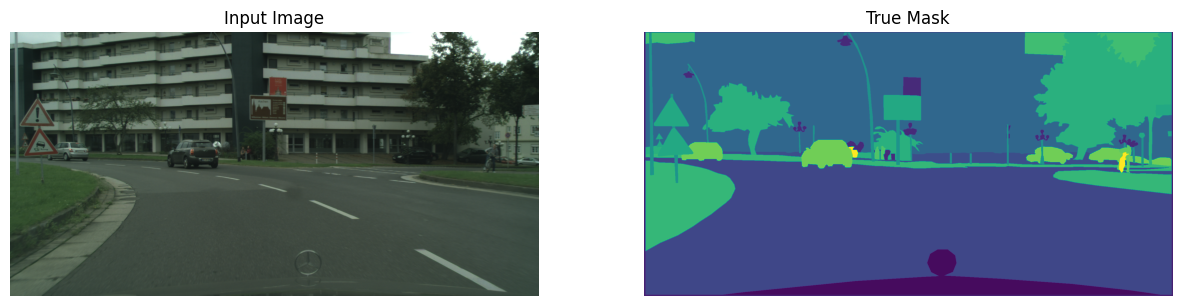

In [12]:
for image, mask in src_ds.take(1): # Original Data
    sample_src, sample_seg = image, mask
display([sample_src, sample_seg])

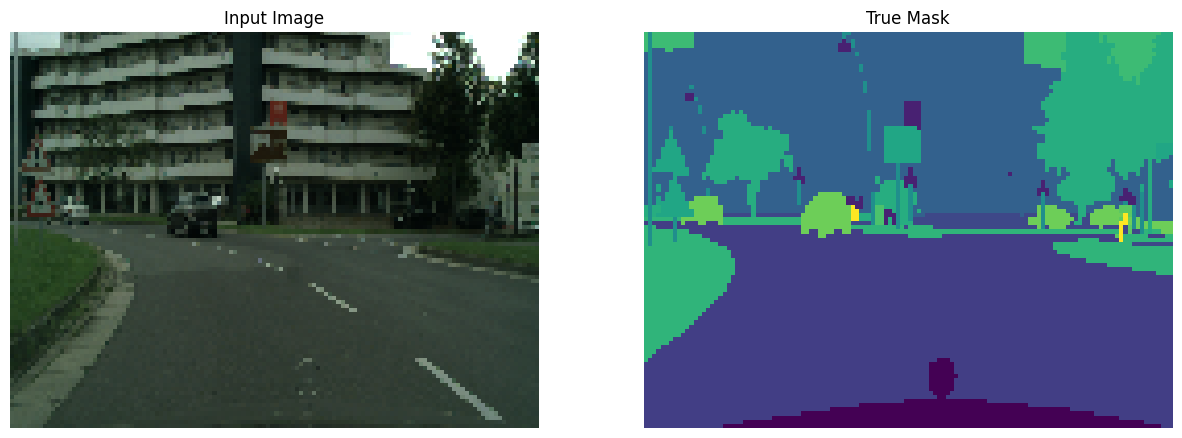

In [13]:
for image, mask in processed_src_ds.take(1):
    sample_src, sample_seg = image, mask
display([sample_src, sample_seg])

# Train Model

In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_src_ds.batch(BATCH_SIZE)
train_dataset = processed_src_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

# Display Metrics

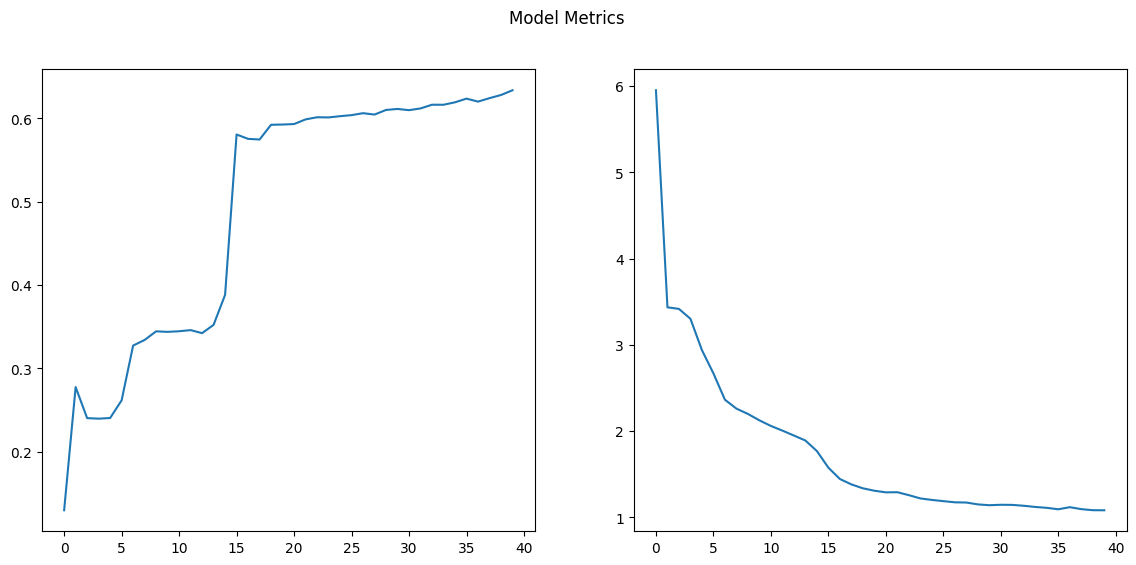

In [105]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history["accuracy"])

plt.subplot(1, 2, 2)
plt.plot(model_history.history["loss"])

plt.suptitle("Model Metrics")
plt.show()

# Generate Predictions

2023-05-10 11:08:46.760105: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 1s 678ms/step


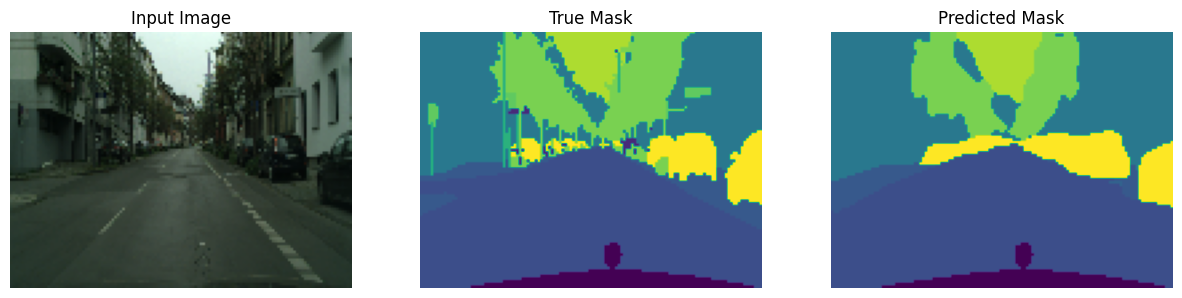

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

train_dataset = processed_src_ds.cache().shuffle(500).batch(32)
show_predictions(train_dataset)